# Model Architecture Deep Dive

**Module 01 | Notebook 2 of 2**

In this notebook, we'll explore the internal architecture of transformer models to understand how they process information.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Distinguish between Encoder, Decoder, and Encoder-Decoder architectures
2. Understand how attention mechanisms work
3. Analyze model parameters and memory requirements
4. Choose the right architecture for your task

---

In [1]:
%%capture
!pip install transformers torch matplotlib seaborn pandas

In [2]:
import torch
from transformers import (
    AutoModel, AutoTokenizer, AutoConfig,
    BertModel, GPT2Model, T5Model,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## Transformer Architecture Types

There are three main types of transformer architectures:

### Architecture Overview

| Type | Examples | Best For | How It Works |
|------|----------|----------|-------------|
| **Encoder-only** | BERT, RoBERTa, DistilBERT | Classification, NER, embeddings | Bidirectional attention |
| **Decoder-only** | GPT-2, GPT-3, LLaMA | Text generation | Causal (left-to-right) attention |
| **Encoder-Decoder** | T5, BART, mT5 | Translation, summarization | Cross-attention between encoder/decoder |

```
┌─────────────────────────────────────────────────────────────────────────┐
│                        Transformer Architectures                        │
├─────────────────────┬───────────────────────┬───────────────────────────┤
│    ENCODER-ONLY     │     DECODER-ONLY      │     ENCODER-DECODER       │
│    (e.g., BERT)     │     (e.g., GPT)       │     (e.g., T5)            │
├─────────────────────┼───────────────────────┼───────────────────────────┤
│                     │                       │                           │
│  [Input Tokens]     │   [Input Tokens]      │  [Input]    [Output]      │
│        ↓            │         ↓             │     ↓          ↓          │
│  ┌─────────┐        │   ┌─────────┐         │  ┌─────┐   ┌─────┐        │
│  │ Encoder │        │   │ Decoder │         │  │ Enc │──→│ Dec │        │
│  └─────────┘        │   └─────────┘         │  └─────┘   └─────┘        │
│        ↓            │         ↓             │               ↓           │
│  [Embeddings]       │   [Next Token]        │         [Output]          │
│                     │                       │                           │
│  Bidirectional      │   Left-to-Right       │     Cross-Attention       │
└─────────────────────┴───────────────────────┴───────────────────────────┘
```

In [3]:
# Load examples of each architecture type
encoder_model = "bert-base-uncased"
decoder_model = "gpt2"
seq2seq_model = "t5-small"

# Get configurations
encoder_config = AutoConfig.from_pretrained(encoder_model)
decoder_config = AutoConfig.from_pretrained(decoder_model)
seq2seq_config = AutoConfig.from_pretrained(seq2seq_model)

print("Model Configurations:")
print("=" * 50)
print(f"\nBERT (Encoder-only):")
print(f"  Hidden size: {encoder_config.hidden_size}")
print(f"  Layers: {encoder_config.num_hidden_layers}")
print(f"  Attention heads: {encoder_config.num_attention_heads}")

print(f"\nGPT-2 (Decoder-only):")
print(f"  Hidden size: {decoder_config.hidden_size}")
print(f"  Layers: {decoder_config.n_layer}")
print(f"  Attention heads: {decoder_config.n_head}")

print(f"\nT5 (Encoder-Decoder):")
print(f"  Hidden size: {seq2seq_config.d_model}")
print(f"  Encoder layers: {seq2seq_config.num_layers}")
print(f"  Decoder layers: {seq2seq_config.num_decoder_layers}")
print(f"  Attention heads: {seq2seq_config.num_heads}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Model Configurations:

BERT (Encoder-only):
  Hidden size: 768
  Layers: 12
  Attention heads: 12

GPT-2 (Decoder-only):
  Hidden size: 768
  Layers: 12
  Attention heads: 12

T5 (Encoder-Decoder):
  Hidden size: 512
  Encoder layers: 6
  Decoder layers: 6
  Attention heads: 8


---

## Understanding Attention

### What is Attention?

Attention allows the model to focus on relevant parts of the input when processing each token.

```
Query: "What does 'it' refer to?"

Sentence: "The cat sat on the mat because it was comfortable."
                                          ↑
                                         'it'
                                          │
            ┌─────────────────────────────┘
            │
            ▼
Attention:  The  cat  sat  on  the  mat  because  it  was  comfortable
           [0.1][0.7][0.1][0.0][0.0][0.1]  [0.0] [1.0][0.0]    [0.0]
```

The model learns that "it" most likely refers to "cat" (high attention weight).

In [4]:
# Load BERT with attention outputs
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
model.eval()

# Tokenize a sentence
text = "The cat sat on the mat."
inputs = tokenizer(text, return_tensors="pt")

# Get outputs with attention
with torch.no_grad():
    outputs = model(**inputs)

# Attention shape: (batch, num_heads, seq_len, seq_len)
attentions = outputs.attentions

print(f"Number of layers: {len(attentions)}")
print(f"Attention shape per layer: {attentions[0].shape}")
print(f"  - Batch size: {attentions[0].shape[0]}")
print(f"  - Attention heads: {attentions[0].shape[1]}")
print(f"  - Sequence length: {attentions[0].shape[2]}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Number of layers: 12
Attention shape per layer: torch.Size([1, 12, 9, 9])
  - Batch size: 1
  - Attention heads: 12
  - Sequence length: 9


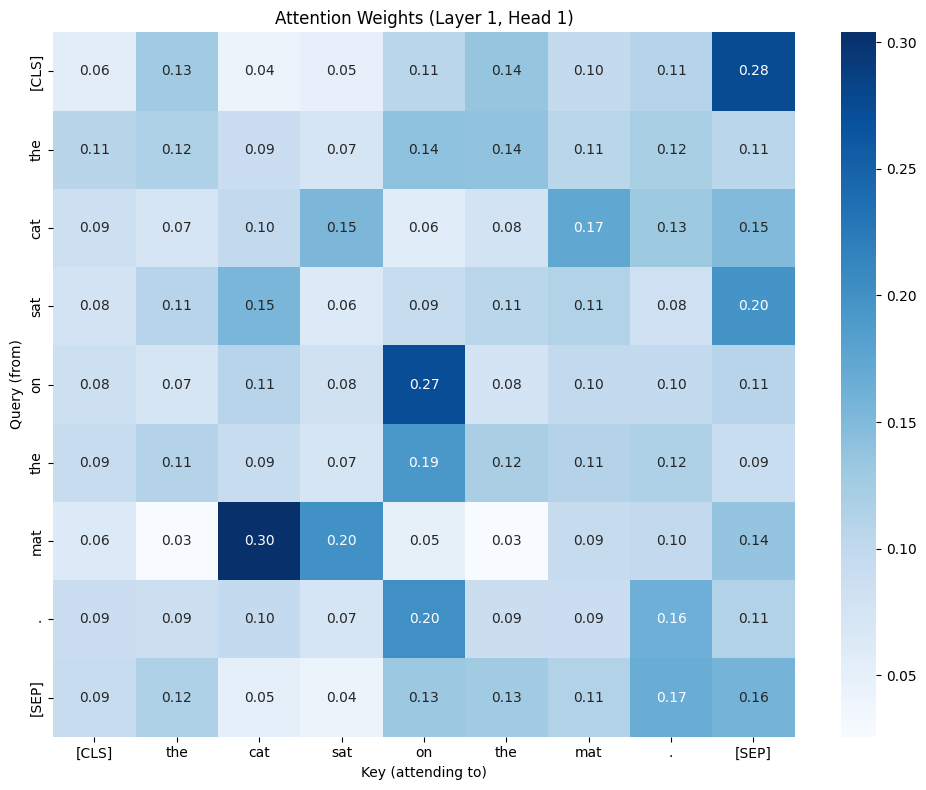

In [5]:
# Visualize attention for one layer and head
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Get attention from first layer, first head
attention = attentions[0][0, 0].numpy()  # Layer 0, Head 0

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    attention,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap='Blues',
    annot=True,
    fmt='.2f'
)
plt.title('Attention Weights (Layer 1, Head 1)')
plt.xlabel('Key (attending to)')
plt.ylabel('Query (from)')
plt.tight_layout()
plt.show()

### Bidirectional vs. Causal Attention

- **Bidirectional (Encoder)**: Each token can attend to ALL tokens
- **Causal (Decoder)**: Each token can only attend to PREVIOUS tokens

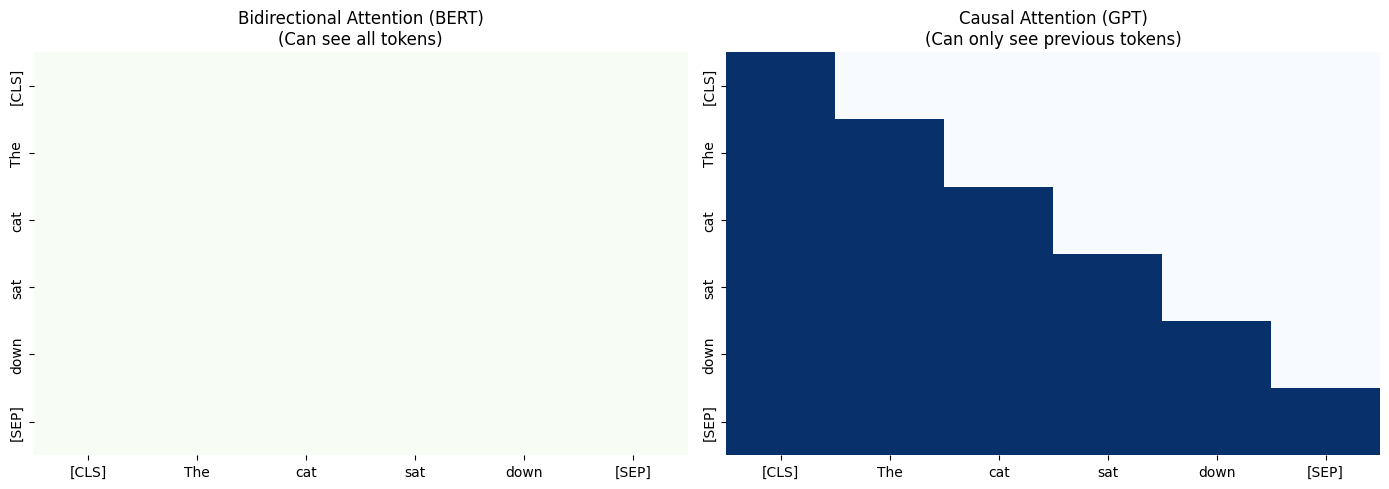

In [6]:
# Visualize attention patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

seq_len = 6
tokens = ['[CLS]', 'The', 'cat', 'sat', 'down', '[SEP]']

# Bidirectional (full attention)
bidirectional = torch.ones(seq_len, seq_len)

# Causal (lower triangular)
causal = torch.tril(torch.ones(seq_len, seq_len))

# Plot bidirectional
sns.heatmap(bidirectional, ax=axes[0], cmap='Greens', cbar=False,
            xticklabels=tokens, yticklabels=tokens)
axes[0].set_title('Bidirectional Attention (BERT)\n(Can see all tokens)')

# Plot causal
sns.heatmap(causal, ax=axes[1], cmap='Blues', cbar=False,
            xticklabels=tokens, yticklabels=tokens)
axes[1].set_title('Causal Attention (GPT)\n(Can only see previous tokens)')

plt.tight_layout()
plt.show()

---

## Parameter Analysis

Understanding model size is crucial for deployment planning.

In [7]:
def count_parameters(model):
    """Count trainable and total parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def get_model_size_mb(model):
    """Estimate model size in MB (assuming float32)."""
    total_params, _ = count_parameters(model)
    return total_params * 4 / (1024 ** 2)  # 4 bytes per float32

# Load models for comparison
models_to_compare = [
    ("distilbert-base-uncased", "DistilBERT"),
    ("bert-base-uncased", "BERT-base"),
    ("bert-large-uncased", "BERT-large"),
]

comparison_data = []

for model_name, display_name in models_to_compare:
    print(f"Loading {display_name}...")
    model = AutoModel.from_pretrained(model_name)
    config = model.config
    total, trainable = count_parameters(model)
    size_mb = get_model_size_mb(model)
    
    comparison_data.append({
        "Model": display_name,
        "Parameters (M)": total / 1e6,
        "Size (MB)": size_mb,
        "Layers": config.num_hidden_layers,
        "Hidden Size": config.hidden_size,
        "Attention Heads": config.num_attention_heads
    })
    del model

df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print(df.to_string(index=False))

Loading DistilBERT...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading BERT-base...
Loading BERT-large...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]


     Model  Parameters (M)   Size (MB)  Layers  Hidden Size  Attention Heads
DistilBERT       66.362880  253.154297       6          768               12
 BERT-base      109.482240  417.641602      12          768               12
BERT-large      335.141888 1278.464844      24         1024               16


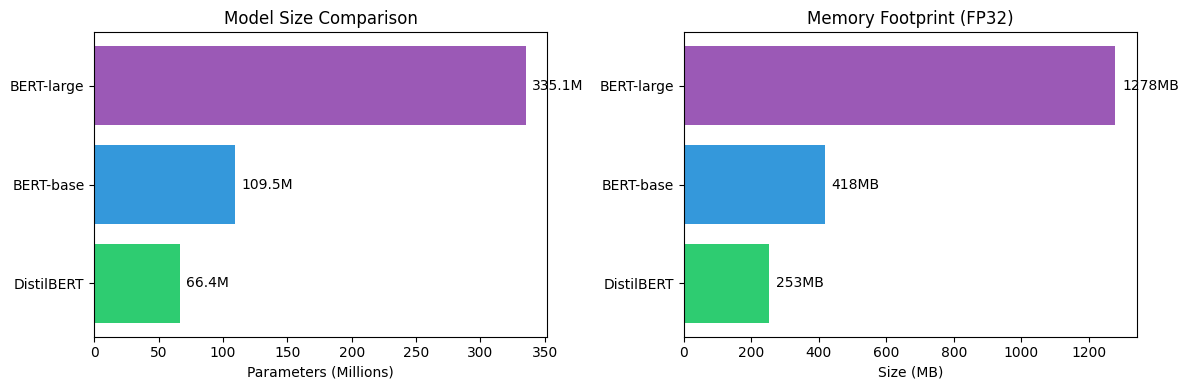

In [8]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Parameter count
axes[0].barh(df['Model'], df['Parameters (M)'], color=['#2ecc71', '#3498db', '#9b59b6'])
axes[0].set_xlabel('Parameters (Millions)')
axes[0].set_title('Model Size Comparison')
for i, v in enumerate(df['Parameters (M)']):
    axes[0].text(v + 5, i, f'{v:.1f}M', va='center')

# Memory size
axes[1].barh(df['Model'], df['Size (MB)'], color=['#2ecc71', '#3498db', '#9b59b6'])
axes[1].set_xlabel('Size (MB)')
axes[1].set_title('Memory Footprint (FP32)')
for i, v in enumerate(df['Size (MB)']):
    axes[1].text(v + 20, i, f'{v:.0f}MB', va='center')

plt.tight_layout()
plt.show()

---

## Layer-by-Layer Analysis

In [9]:
# Detailed layer analysis for BERT
model = BertModel.from_pretrained("bert-base-uncased")

# Analyze each component
layer_params = {}

for name, param in model.named_parameters():
    # Group by first two levels
    parts = name.split('.')
    if len(parts) >= 2:
        group = f"{parts[0]}.{parts[1]}"
    else:
        group = parts[0]
    
    if group not in layer_params:
        layer_params[group] = 0
    layer_params[group] += param.numel()

# Sort by parameter count
sorted_layers = sorted(layer_params.items(), key=lambda x: x[1], reverse=True)

print("BERT Parameter Distribution:")
print("=" * 50)
total = sum(layer_params.values())
for name, count in sorted_layers[:10]:
    pct = count / total * 100
    print(f"{name:40s} {count:>12,} ({pct:>5.1f}%)")

BERT Parameter Distribution:
encoder.layer                              85,054,464 ( 77.7%)
embeddings.word_embeddings                 23,440,896 ( 21.4%)
pooler.dense                                  590,592 (  0.5%)
embeddings.position_embeddings                393,216 (  0.4%)
embeddings.token_type_embeddings                1,536 (  0.0%)
embeddings.LayerNorm                            1,536 (  0.0%)


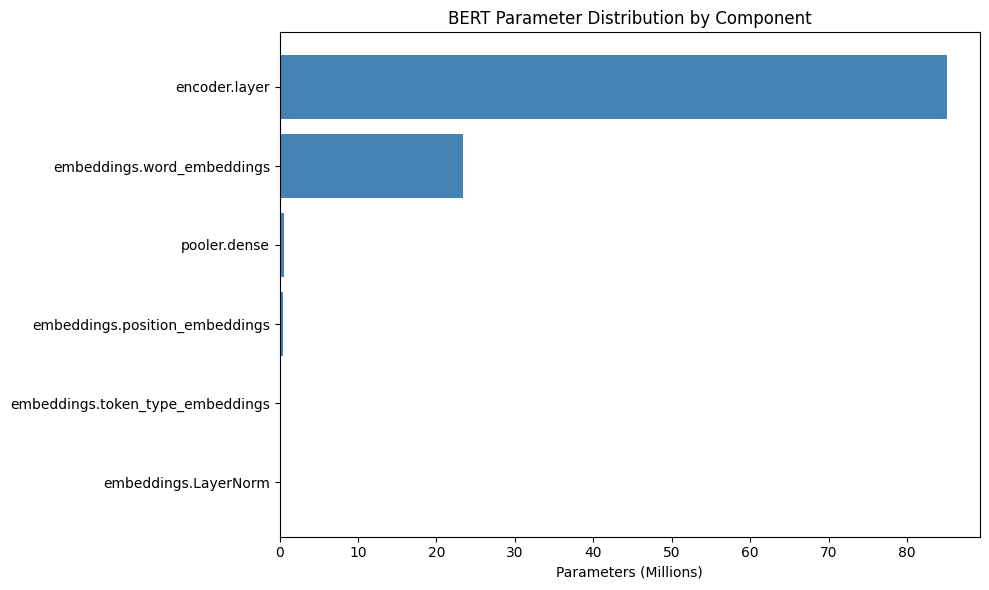

In [10]:
# Visualize parameter distribution
labels = [name for name, _ in sorted_layers[:8]]
sizes = [count / 1e6 for _, count in sorted_layers[:8]]

plt.figure(figsize=(10, 6))
plt.barh(labels, sizes, color='steelblue')
plt.xlabel('Parameters (Millions)')
plt.title('BERT Parameter Distribution by Component')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---

## Memory Requirements

### Memory During Training vs. Inference

| Phase | What's Stored | Memory Factor |
|-------|---------------|---------------|
| **Inference** | Model weights only | 1x |
| **Training** | Weights + Gradients + Optimizer states | ~4x |

### Precision Impact

| Precision | Bytes per Param | Example (110M params) |
|-----------|-----------------|---------------------|
| FP32 | 4 | 440 MB |
| FP16/BF16 | 2 | 220 MB |
| INT8 | 1 | 110 MB |

In [11]:
def estimate_memory(model, batch_size=8, seq_length=512, precision='fp32'):
    """Estimate memory requirements for inference."""
    total_params, _ = count_parameters(model)
    
    # Bytes per parameter
    bytes_per_param = {'fp32': 4, 'fp16': 2, 'int8': 1}[precision]
    
    # Model weights
    model_memory = total_params * bytes_per_param
    
    # Activation memory (rough estimate)
    hidden_size = model.config.hidden_size
    num_layers = model.config.num_hidden_layers
    activation_memory = batch_size * seq_length * hidden_size * num_layers * bytes_per_param
    
    return {
        'model_mb': model_memory / (1024**2),
        'activation_mb': activation_memory / (1024**2),
        'total_mb': (model_memory + activation_memory) / (1024**2)
    }

# Compare memory for different precisions
model = BertModel.from_pretrained("bert-base-uncased")

print("Memory Estimates for BERT-base (batch=8, seq=512):")
print("=" * 60)

for precision in ['fp32', 'fp16', 'int8']:
    mem = estimate_memory(model, precision=precision)
    print(f"\n{precision.upper()}:")
    print(f"  Model weights: {mem['model_mb']:.1f} MB")
    print(f"  Activations:   {mem['activation_mb']:.1f} MB")
    print(f"  Total:         {mem['total_mb']:.1f} MB")

Memory Estimates for BERT-base (batch=8, seq=512):

FP32:
  Model weights: 417.6 MB
  Activations:   144.0 MB
  Total:         561.6 MB

FP16:
  Model weights: 208.8 MB
  Activations:   72.0 MB
  Total:         280.8 MB

INT8:
  Model weights: 104.4 MB
  Activations:   36.0 MB
  Total:         140.4 MB


---

## Choosing the Right Architecture

### Decision Tree

```
                        What's your task?
                              │
          ┌───────────────────┼───────────────────┐
          │                   │                   │
     Understanding       Generation         Transformation
     (Classification,    (Text gen,        (Translation,
      NER, QA)           Completion)        Summarization)
          │                   │                   │
          ▼                   ▼                   ▼
     ENCODER-ONLY        DECODER-ONLY       ENCODER-DECODER
     (BERT, RoBERTa)     (GPT-2, LLaMA)     (T5, BART)
```

In [12]:
# Quick reference table
architecture_guide = pd.DataFrame({
    'Task': [
        'Sentiment Analysis',
        'Named Entity Recognition',
        'Text Classification',
        'Text Generation',
        'Chatbot/Dialogue',
        'Translation',
        'Summarization',
        'Question Answering'
    ],
    'Architecture': [
        'Encoder (BERT)',
        'Encoder (BERT)',
        'Encoder (BERT)',
        'Decoder (GPT)',
        'Decoder (GPT)',
        'Encoder-Decoder (T5)',
        'Encoder-Decoder (BART)',
        'Encoder or Enc-Dec'
    ],
    'Recommended Model': [
        'distilbert-base-uncased',
        'bert-base-cased',
        'roberta-base',
        'gpt2 / gpt2-medium',
        'facebook/blenderbot-400M-distill',
        't5-base / mbart-large-50',
        'facebook/bart-large-cnn',
        'deepset/roberta-base-squad2'
    ]
})

print("Architecture Selection Guide")
print("=" * 80)
print(architecture_guide.to_string(index=False))

Architecture Selection Guide
                    Task           Architecture                Recommended Model
      Sentiment Analysis         Encoder (BERT)          distilbert-base-uncased
Named Entity Recognition         Encoder (BERT)                  bert-base-cased
     Text Classification         Encoder (BERT)                     roberta-base
         Text Generation          Decoder (GPT)               gpt2 / gpt2-medium
        Chatbot/Dialogue          Decoder (GPT) facebook/blenderbot-400M-distill
             Translation   Encoder-Decoder (T5)         t5-base / mbart-large-50
           Summarization Encoder-Decoder (BART)          facebook/bart-large-cnn
      Question Answering     Encoder or Enc-Dec      deepset/roberta-base-squad2


---

## 🎯 Student Challenge

### Challenge 1: Compare T5 Model Sizes

Load `t5-small`, `t5-base`, and `t5-large`, then create a comparison table.

In [ ]:
# TODO: Your code here
# 1. Load each T5 variant
# 2. Count parameters and estimate memory
# 3. Create a comparison DataFrame
# 4. Visualize with a bar chart

t5_variants = ["t5-small", "t5-base"]  # Add t5-large if you have enough memory

# Your solution:


### Challenge 2: Attention Visualization

Visualize attention patterns for a longer sentence across multiple layers.

In [ ]:
# TODO: Your code here
# 1. Use BERT with output_attentions=True
# 2. Tokenize: "The quick brown fox jumps over the lazy dog."
# 3. Create a 2x2 grid showing attention from layers 1, 4, 8, 12

# Your solution:


---

## Key Takeaways

1. **Encoder models** (BERT) use bidirectional attention for understanding
2. **Decoder models** (GPT) use causal attention for generation
3. **Encoder-Decoder models** (T5) combine both for sequence-to-sequence tasks
4. **Model size** impacts memory, latency, and accuracy
5. **Precision reduction** (FP16, INT8) can significantly reduce memory

---

## Next Steps

Continue to Module 02: **Fine-Tuning**
- `02_Fine_Tuning/01_transfer_learning.ipynb`